# Software Engineering Project 1 - Release 2

### Farshad Bolouri - Jorge Carlos - Davis Okuzor - Logan Campbell

In [1]:
import os
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

% matplotlib inline

Using TensorFlow backend.


In [2]:
gestures = {'L_': 'L',
           'fi': 'Fist',
           'C_': 'C',
           'ok': 'Okay',
           'pe': 'Peace',
           'pa': 'Palm'
            }

gestures_map = {'Fist' : 0,
                'L': 1,
                'Okay': 2,
                'Palm': 3,
                'Peace': 4
                }

In [56]:
def process_image(path):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    if rgb:
        pass
    else:
        X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    y_data = to_categorical(y_data)
    return X_data, y_data

def walk_file_tree(relative_path):
    X_data = []
    y_data = [] 
    for directory, subdirectories, files in os.walk(relative_path):
        for file in files:
            if not file.startswith('.') and (not file.startswith('C_')):
                path = os.path.join(directory, file)
                gesture_name = gestures[file[0:2]]
                y_data.append(gestures_map[gesture_name])
                X_data.append(process_image(path))   

            else:
                continue

    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

#### Get 'silhouette' data

Notice we aren't using any filters for preprocessing this dataset as it already look like the images that are going to be outputted from the hand gesture extraction feature in release 1.

In [54]:
relative_path = 'C:/Users/farsh/Downloads/Datasets/frames/silhouettes/'
rgb = False

# # This method processes the data
X_data, y_data = walk_file_tree(relative_path)

# Can also optionally use a class to get this data, in order to keep it separate from Drawing data
silhouette = Data()
silhouette.X_data, silhouette.y_data = walk_file_tree(relative_path)

In [33]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (2748, 224, 224, 3)
y_data shape: (2748, 5)


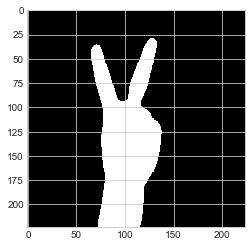

In [34]:
plt.imshow(X_data[0])

#### Bring in Kaggle data

We're going to use the same filters as we used for hand gesture extraction from webcam in release 1, so our kaggle dataset would also look like the 'silhouette' dataset and our future input data to the model from webcam

In [ ]:
gestures_map = {3: 0,
                2: 1,
                7: 2,
                1: 3,
                'Peace': 4
                }
X_data = []
y_data = []

root_dir = os.fsencode('C:/Users/farsh/Downloads/Datasets/gestures_data/')

for directory, subdirectories, files in os.walk(root_dir):
    for file in files:
        if not file.startswith(b'.'):
            gesture_name = int(file.decode('utf8')[10:11])
            if gesture_name in [1, 2, 3, 7]:
                path = os.path.join(directory, file).decode('utf8')
                y_data.append(gestures_map[gesture_name])

                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.flip(img, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.GaussianBlur(gray, (41, 41), 0)  #tuple indicates blur value
                ret, thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                thresh = cv2.resize(thresh, (224, 224))
                thresh = np.array(thresh)
                X_data.append(thresh)

            else:
                continue

process_data(X_data, y_data)


In [ ]:
# Have to add a column of zeroes for the 'Peace' sign, since the Kaggle data does not have photos of 
# 'Peace' signs.
z = np.zeros((len(y_data),1))
y_data = np.append(y_data, z, axis=1)

In [59]:
y_data.shape

(8000, 5)

#### Notice that the Kaggle images are now thresholded and binarized

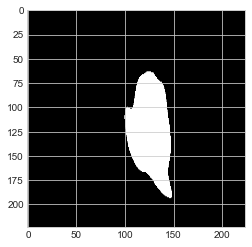

In [76]:
plt.imshow(.5 - X_data[250])

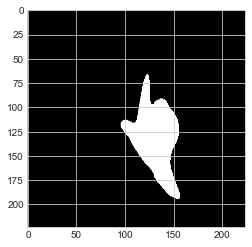

In [81]:
plt.imshow(.5 - X_data[100])

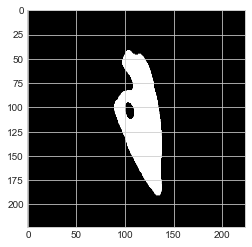

In [83]:
plt.imshow(.5 - X_data[1200])

#### Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state=12, stratify=y_data)

#### Build the VGG Model

In [40]:
file_path = 'C:/Users/farsh/Downloads/models/saved_model.hdf5'
model_checkpoint = ModelCheckpoint(filepath=file_path, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)


In [ ]:
# load VGG16
# Get back the convolutional part of a VGG network trained on ImageNet

imageSize = 224
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

base_model = model1  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', name='fc4')(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_train, y_train), verbose=1,
          callbacks=[early_stopping, model_checkpoint])

model = save_model('./models/SoftwareEnigneering_Project1_Model.h5')

#### Get classification metrics

In [48]:
def get_classification_metrics(X_test, y_test):
    pred = model.predict(X_test)
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_true, pred))
    print('\n')
    print(classification_report(y_true, pred))

**Note that there are no predictions for class \#5 since 'Peace' sign did not exist in the Test images**

In [49]:
get_classification_metrics(X_data, y_data)

[[200   0   0   0   0]
 [  0 199   0   1   0]
 [  0   0 200   0   0]
 [ 11   0   0 187   2]
 [  0   0   0   0   0]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       200
           1       1.00      0.99      1.00       200
           2       1.00      1.00      1.00       200
           3       0.99      0.94      0.96       200
           4       0.00      0.00      0.00         0

   micro avg       0.98      0.98      0.98       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.99      0.98      0.98       800

